<a href="https://colab.research.google.com/github/Janardan-thapaliya/Deep_Learning_SNN/blob/main/N_MNIST_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.2 MB/s eta 0:00:00


In [8]:
import os
import torch
import torch.nn as nn
import numpy as np
import snntorch as snn
import snntorch.functional as SF
import torch.optim as optim
import zipfile
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Download and extract dataset
!kaggle datasets download -d khoahongg/n-mnist
with zipfile.ZipFile('/content/n-mnist.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

# Function to read N-MNIST binary files
def read_nmnist_file(file_path):
    x_coords, y_coords, polarities, timestamps = [], [], [], []
    with open(file_path, 'rb') as f:
        data = f.read()
        for i in range(0, len(data), 5):
            event = int.from_bytes(data[i:i+5], byteorder='big')
            x_coords.append((event >> 32) & 0xFF)
            y_coords.append((event >> 24) & 0xFF)
            polarities.append((event >> 23) & 0x01)
            timestamps.append(event & 0x7FFFFF)
    return x_coords, y_coords, polarities, timestamps

# Convert events to spike train
def event_to_spike_train(x, y, p, t, delta_t=1000, max_steps=350):
    spike_train = torch.zeros(max_steps, 34*34)
    for x_, y_, p_, t_ in zip(x, y, p, t):
        spike_train[t_ // delta_t, y_ * 34 + x_] = 1
    return spike_train

# Custom dataset class
class NMNISTDataset(Dataset):
    def __init__(self, file_paths, delta_t=1000, max_steps=350):
        self.file_paths = file_paths
        self.delta_t = delta_t
        self.max_steps = max_steps

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path, target = self.file_paths[idx]
        x, y, p, t = read_nmnist_file(file_path)
        spike_train = event_to_spike_train(x, y, p, t, self.delta_t, self.max_steps)
        return spike_train, target

# Get file paths and targets
def get_file_paths(root_dir):
    return [(os.path.join(root, file), int(os.path.basename(root)))
            for root, _, files in os.walk(root_dir) for file in files]

train_files = get_file_paths('/content/Train/Train')
test_files = get_file_paths('/content/Test/Test')
train_dataset = NMNISTDataset(train_files)
test_dataset = NMNISTDataset(test_files)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Spiking Neural Network
class SNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta1):
        super().__init__()
        beta2 = torch.rand((num_outputs), dtype=torch.float)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta1)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta2, learn_beta=True)

    def forward(self, x):
        mem1, mem2 = self.lif1.init_leaky(), self.lif2.init_leaky()
        spk2_rec, mem2_rec = [], []
        for step in range(x.shape[1]):
            spk1, mem1 = self.lif1(self.fc1(x[:, step, :]), mem1)
            spk2, mem2 = self.lif2(self.fc2(spk1), mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec), torch.stack(mem2_rec)

# Initialize model
net = SNN(num_inputs=1156, num_hidden=128, num_outputs=10, beta1=0.8)
optimizer = optim.Adam(net.parameters(), lr=5e-3)
loss_fn = SF.ce_rate_loss()

# Training loop
num_epochs = 30
num_steps = 350
loss_hist, acc_hist = [], []

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(train_loader):
        net.train()
        spk_rec, _ = net(data)
        loss_val = loss_fn(spk_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        loss_hist.append(loss_val.item())
        if i % 5 == 0:
            net.eval()
            acc = SF.accuracy_rate(spk_rec, targets)
            acc_hist.append(acc)
            print(f"Epoch {epoch}, Iteration {i} - Loss: {loss_val.item():.2f}, Accuracy: {acc * 100:.2f}%")
        if i == 50:
            break

Dataset URL: https://www.kaggle.com/datasets/khoahongg/n-mnist
License(s): unknown
n-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Epoch 0, Iteration 0 - Loss: 2.30, Accuracy: 9.38%
Epoch 0, Iteration 5 - Loss: 2.28, Accuracy: 12.50%
Epoch 0, Iteration 10 - Loss: 2.30, Accuracy: 12.50%
Epoch 0, Iteration 15 - Loss: 2.24, Accuracy: 28.12%
Epoch 0, Iteration 20 - Loss: 2.23, Accuracy: 34.38%
Epoch 0, Iteration 25 - Loss: 2.22, Accuracy: 28.12%
Epoch 0, Iteration 30 - Loss: 2.13, Accuracy: 56.25%
Epoch 0, Iteration 35 - Loss: 2.16, Accuracy: 40.62%
Epoch 0, Iteration 40 - Loss: 2.10, Accuracy: 43.75%
Epoch 0, Iteration 45 - Loss: 2.08, Accuracy: 53.12%
Epoch 0, Iteration 50 - Loss: 2.14, Accuracy: 50.00%
Epoch 1, Iteration 0 - Loss: 1.96, Accuracy: 71.88%
Epoch 1, Iteration 5 - Loss: 2.05, Accuracy: 43.75%
Epoch 1, Iteration 10 - Loss: 1.99, Accuracy: 68.75%
Epoch 1, Iteration 15 - Loss: 2.07, Accuracy: 59.38%
Epoch 1, Iteration 20 - Loss: 1.

In [9]:
# Evaluation on test dataset
def test_model(model, test_loader):
    model.eval()
    total_acc = 0
    num_batches = 0

    with torch.no_grad():
        for data, targets in test_loader:
            spk_rec, _ = model(data)
            acc = SF.accuracy_rate(spk_rec, targets)
            total_acc += acc
            num_batches += 1

    avg_acc = total_acc / num_batches
    print(f"Test Accuracy: {avg_acc * 100:.2f}%")
    return avg_acc

# Run the test
test_accuracy = test_model(net, test_loader)

Test Accuracy: 90.61%


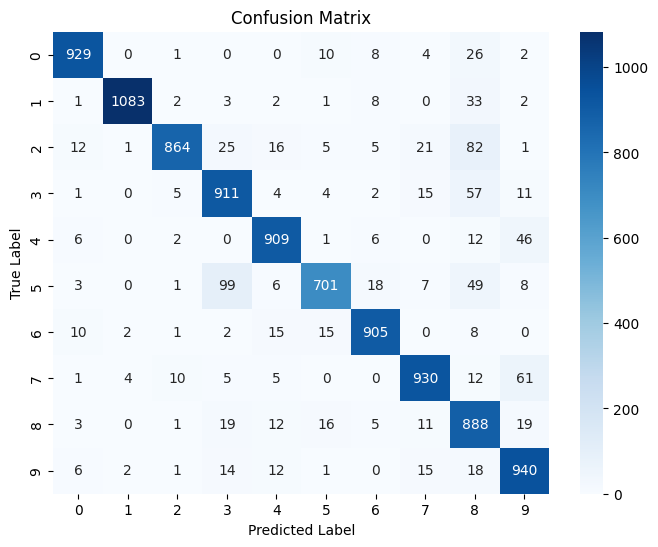

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to compute and plot confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in test_loader:
            spk_rec, _ = model(data)
            preds = torch.sum(spk_rec, dim=0).argmax(dim=1)  # Get predicted labels
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run confusion matrix function
plot_confusion_matrix(net, test_loader)